### Cursory overview of  bond yield curve

Bond yield curve is yield to maturity for bond with different maturity.

This notebook illustrates the below concepts using UK Gilt prices:

* calculation of par yield from bond prices of different maturities
* Interpolation of yield curve
* bootstrapping of spot rates from yield curves

UK Gilt prices are sourced from https://www.fixedincomeinvestor.co.uk/x/bondtable.html

In [1]:
import pandas as pd
import scipy
import numpy as np
from datetime import datetime
import bondfns

bond_data = pd.read_csv('./data/gilts_2020_03_18.csv', index_col = None, parse_dates=['Maturity'])
print(bond_data.shape)
print(sorted([dt.date() for dt in bond_data['Maturity'].to_list()]))

(29, 9)
[datetime.date(2020, 9, 7), datetime.date(2021, 1, 22), datetime.date(2021, 6, 7), datetime.date(2021, 9, 7), datetime.date(2022, 3, 7), datetime.date(2022, 7, 9), datetime.date(2022, 7, 22), datetime.date(2023, 9, 7), datetime.date(2024, 9, 7), datetime.date(2025, 3, 7), datetime.date(2025, 9, 7), datetime.date(2026, 6, 22), datetime.date(2027, 12, 7), datetime.date(2028, 12, 7), datetime.date(2030, 12, 7), datetime.date(2032, 6, 7), datetime.date(2034, 9, 7), datetime.date(2036, 3, 7), datetime.date(2038, 12, 7), datetime.date(2039, 9, 7), datetime.date(2040, 12, 7), datetime.date(2042, 12, 7), datetime.date(2045, 1, 22), datetime.date(2046, 12, 7), datetime.date(2049, 12, 7), datetime.date(2055, 12, 7), datetime.date(2060, 1, 22), datetime.date(2065, 7, 22), datetime.date(2068, 7, 22)]


*bond_data* conatins prices and coupon for bonds of various maturities (from 6m to 48Y).

Below code calculates yield to maturity by solving bond PV formula using newton method : 

$ PV = \frac{c}{y} \left(1-\frac{1}{(1+y)^n} \right) + \frac{FV}{(1+y)^n}$

In [2]:
today = datetime(2020, 3, 19)
ttm = [(maturity - today).days / 360 for maturity in bond_data['Maturity']]
bond_data['ttm'] = ttm

ttm_list, ytm_list = [], []
freq = 2 # semi-annual
for i, row in bond_data.iterrows():
    ttm = row['ttm']
    price = row['Price']
    cpn = row['Cpn']
    ytm = bondfns.calc_ytm(price, ttm, freq , cpn, fv=100)
    ttm_list.append(ttm)
    ytm_list.append(ytm)


In [3]:
max_tnr = 49
interp_ytm = bondfns.interpolate_ytm(ttm_list, ytm_list, max_tnr)

#### Calculate bond par yield or spot rate  by bootstrapping
We can use the interpolated YTM, obtained above, to imply spot rates. Since for a par bond, coupon = yield, we can solve the below equation iteratively for a hypotentical par bond with annual freq and coupon = YTM   

$ \sum_{j=0}^{i-1} \frac{cpn_i}{(1+r_j)^j} + \frac{1+cpn_i}{1+r_j} = 1$


In [5]:
T = list(range(1,max_tnr))
S = []
for i in range(len(T)):
    prev_ann_sum = 0.
    cpn = interp_ytm[i]
    for j in range(i):
        prev_ann_sum += cpn / (1+S[j])**T[j]
    srate = ((1+cpn)/(1-prev_ann_sum))**(1/T[i]) - 1
    S.append(srate)

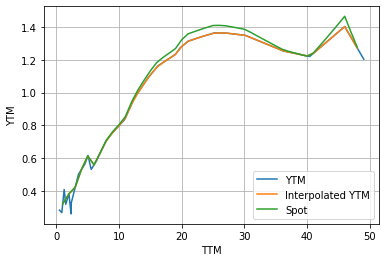

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.xlabel('TTM'),plt.ylabel('YTM'), plt.grid(True)
plt.plot(ttm_list, np.array(ytm_list)*100, label='YTM')
plt.plot(T, np.array(interp_ytm)*100,label='Interpolated YTM')
plt.plot(T, np.array(S)*100, label='Spot')
plt.legend(loc=0), plt.show();